# Quick and Dirty attempt to train a model

In [27]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

In [2]:
bs = 64
## bs = 16  ## for out of memory

In [3]:
data_fp = Path('./data/')

# Looking at the data

In [23]:
labels = pd.read_csv(data_fp/'train.csv')
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


## Split data into training and validation set
Because the data is extremely unbalance where it contains classes with only one sample, we cannot use a random sampling method.   
Fastai will get an error when there is a class in the validation set and not in training set. [link](https://github.com/fastai/fastai/issues/1273)

In addition, we cannot use StratifiedShuffleSplit because the minimum number of groups for any class cannot be less than 2.   
Therefore, we will need to duplicate images for this to work. Instead, we will manually create a train and validation split. 

In [ ]:
# ## Save code just in case for future use
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# ## split is decided by the Id column
# for train_index, val_index in sss.split(labels.index.values, labels.Id):
#     train_idx, val_idx = train_index, val_index  

In [61]:
class_counts = labels.Id.value_counts(sort=True, ascending=True)
print(f'Number of classes with only one image: {sum(class_counts == 1):,}')
print(f'Percentage of classes: {sum(class_counts == 1)/len(labels.Id.unique()):.0%}')

Number of classes with only one image: 2,073
Percentage of classes: 41%


In [63]:
class_counts[::-1][:5]  ## Top 5 most common class

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [5]:
tfms = get_transforms(do_flip=False)

In [6]:
tfms  ## show the the list of image transformation. tfms[1] is for validation/test images

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [28]:
ImageDataBunch.from_csv??

Signature: ImageDataBunch.from_csv(path: Union[pathlib.Path, str], folder: Union[pathlib.Path, str] = '.', sep=None, csv_labels: Union[pathlib.Path, str] = 'labels.csv', valid_pct: float = 0.2, fn_col: int = 0, label_col: int = 1, suffix: str = '', header: Union[int, str, NoneType] = 'infer', **kwargs: Any) -> 'ImageDataBunch'
Source:   
    @classmethod
    def from_csv(cls, path:PathOrStr, folder:PathOrStr='.', sep=None, csv_labels:PathOrStr='labels.csv', valid_pct:float=0.2,
            fn_col:int=0, label_col:int=1, suffix:str='',
            header:Optional[Union[int,str]]='infer', **kwargs:Any)->'ImageDataBunch':
        "Create from a csv file in `path/csv_labels`."
        path = Path(path)
        df = pd.read_csv(path/csv_labels, header=header)
        return cls.from_df(path, df, folder=folder, sep=sep, valid_pct=valid_pct,
                fn_col=fn_col, label_col=label_col, suffix=suffix, header=header, **kwargs)
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/

In [29]:
ImageDataBunch.from_df??

Signature: ImageDataBunch.from_df(path: Union[pathlib.Path, str], df: pandas.core.frame.DataFrame, folder: Union[pathlib.Path, str] = '.', sep=None, valid_pct: float = 0.2, fn_col: Union[int, Collection[int], str, Collection[str]] = 0, label_col: Union[int, Collection[int], str, Collection[str]] = 1, suffix: str = '', **kwargs: Any) -> 'ImageDataBunch'
Source:   
    @classmethod
    def from_df(cls, path:PathOrStr, df:pd.DataFrame, folder:PathOrStr='.', sep=None, valid_pct:float=0.2,
                fn_col:IntsOrStrs=0, label_col:IntsOrStrs=1, suffix:str='',
                **kwargs:Any)->'ImageDataBunch':
        "Create from a `DataFrame` `df`."
        src = (ImageItemList.from_df(df, path=path, folder=folder, suffix=suffix, cols=fn_col)
                .random_split_by_pct(valid_pct)
                .label_from_df(sep=sep, cols=label_col))
        return cls.create_from_ll(src, **kwargs)
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py
Type:      method


In [30]:
tmp = ImageItemList.from_df(path=data_fp, df=labels, cols='Image')

In [31]:
tmp.split_by_idx

fastai.vision.data.ImageItemList

In [12]:
data = ImageDataBunch.from_csv(path=data_fp,
                               folder='train_96',
                               csv_labels='train.csv',
                               fn_col = 'Image',  ## File name column, default = column 0
                               label_col = 'Id',  ## label column, default = column 1
                               ds_tfms=tfms,  ## need this but dont know why
                               size=96,  ## make sure all image are the same size
                               valid_pct = 0.2,  ## percentage of data is used as validation
                               bs=bs)

In [26]:
len(data.classes)

4557

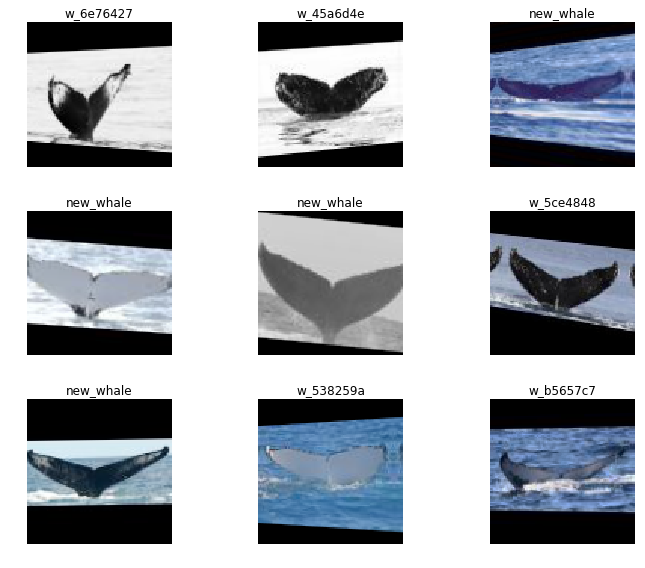

In [13]:
data.show_batch(rows=3, figsize=(10,8))

## Training

In [15]:
learn = create_cnn(data=data, arch=models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 30790834.85it/s]


In [14]:
accuracy??

Signature: accuracy(input: torch.Tensor, targs: torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f2600966d08>
Source:   
def accuracy(input:Tensor, targs:LongTensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [16]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy


TypeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/torch_core.py", line 99, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 223, in default_collate
    return torch.LongTensor(batch)
TypeError: an integer is required (got type NoneType)


In [17]:
data.c

4557

In [18]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_first',
 '_square_show',
 'add_tfm',
 'batch_size',
 'batch_stats',
 'create',
 'create_from_ll',
 'device',
 'dl',
 'dls',
 'export',
 'from_csv',
 'from_df',
 'from_folder',
 'from_lists',
 'from_name_func',
 'from_name_re',
 'load_empty',
 'loss_func',
 'normalize',
 'num_workers',
 'one_batch',
 'one_item',
 'path',
 'show_batch',
 'single_dl',
 'single_ds',
 'single_from_classes',
 'test_dl',
 'test_ds',
 'tfms',
 'train_dl',
 'train_ds',
 'valid_dl',
 'valid_ds']

In [25]:
len(data.classes)

4557